# S&P 500 Forecasting Project - ARIMA Modeling

This notebook implements ARIMA models to forecast S&P 500 closing prices. We'll explore different model parameters, evaluate their performance, and generate forecasts for the target period.

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sys
import os

# Add the src directory to the Python path
sys.path.append(os.path.abspath('../'))

# Import project modules
from src.data_utils import load_sp500_data, calculate_returns, calculate_evaluation_metrics
from src.arima_model import (check_stationarity, find_optimal_arima_params,
                            train_arima_model, forecast_arima,
                            plot_arima_diagnostics, plot_arima_forecast)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

# Set pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

## 2. Load Processed Data

In [2]:
# Load the preprocessed data
data_path = '../data/processed/sp500_processed.csv'
train_path = '../data/processed/sp500_train.csv'
test_path = '../data/processed/sp500_test.csv'

# Check if processed data exists
if os.path.exists(data_path) and os.path.exists(train_path) and os.path.exists(test_path):
    # Load from processed files
    sp500_data = pd.read_csv(data_path, index_col=0, parse_dates=True)
    train_data = pd.read_csv(train_path, index_col=0, parse_dates=True)
    test_data = pd.read_csv(test_path, index_col=0, parse_dates=True)
else:
    # If processed data doesn't exist, load raw data and process it
    raw_data_path = '../data/HistoricalData_1740743587727.csv'
    sp500_data = load_sp500_data(raw_data_path)
    
    # Calculate returns
    sp500_data = calculate_returns(sp500_data)
    
    # Split into training and testing sets
    forecast_dates = pd.date_range(start='2025-02-21', end='2025-02-28', freq='B')
    mask = sp500_data.index.isin(forecast_dates)
    train_data = sp500_data[~mask].copy()
    test_data = sp500_data[mask].copy()

print(f"Data shape: {sp500_data.shape}")
print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Data shape: (2521, 7)
Training data shape: (2516, 7)
Testing data shape: (5, 7)


In [3]:
# Display the actual values for the forecast period
print("Actual values for forecast period:")
test_data['Close/Last']

Actual values for forecast period:


Date
2025-02-21    6013.13
2025-02-24    5983.25
2025-02-25    5955.25
2025-02-26    5956.06
2025-02-27    5861.57
Name: Close/Last, dtype: float64

## 3. Check Stationarity

In [4]:
# Check stationarity of closing prices
is_stationary, test_results = check_stationarity(train_data['Close/Last'])

print("Stationarity Test for Closing Prices:")
print(f"ADF Statistic: {test_results['ADF Statistic']:.4f}")
print(f"p-value: {test_results['p-value']:.4f}")
print("Critical Values:")
for key, value in test_results['Critical Values'].items():
    print(f"\t{key}: {value:.4f}")

if is_stationary:
    print("Conclusion: The series is stationary (reject the null hypothesis)")
else:
    print("Conclusion: The series is non-stationary (fail to reject the null hypothesis)")

Stationarity Test for Closing Prices:
ADF Statistic: 0.6819
p-value: 0.9895
Critical Values:
	1%: -3.4330
	5%: -2.8627
	10%: -2.5674
Conclusion: The series is non-stationary (fail to reject the null hypothesis)



Stationarity Test for First Differenced Closing Prices:
ADF Statistic: -16.0141
p-value: 0.0000
Critical Values:
	1%: -3.4330
	5%: -2.8627
	10%: -2.5674
Conclusion: The differenced series is stationary (reject the null hypothesis)


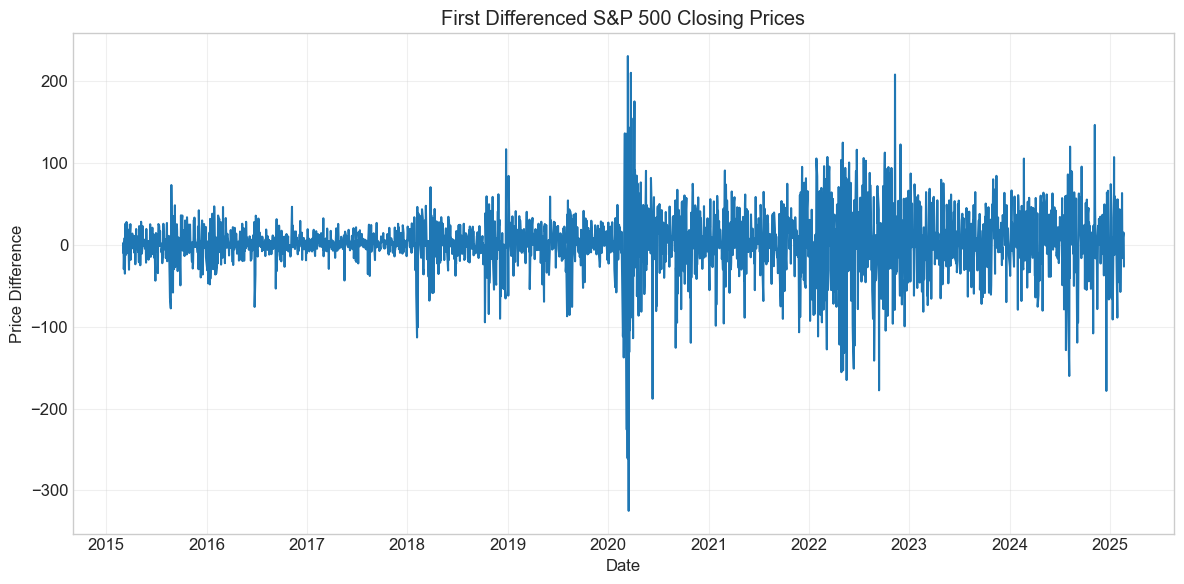

In [5]:
# If not stationary, take first difference and check again
if not is_stationary:
    # Calculate first difference
    train_data['Close_Diff'] = train_data['Close/Last'].diff()
    
    # Check stationarity of differenced series
    is_stationary_diff, test_results_diff = check_stationarity(train_data['Close_Diff'].dropna())
    
    print("\nStationarity Test for First Differenced Closing Prices:")
    print(f"ADF Statistic: {test_results_diff['ADF Statistic']:.4f}")
    print(f"p-value: {test_results_diff['p-value']:.4f}")
    print("Critical Values:")
    for key, value in test_results_diff['Critical Values'].items():
        print(f"\t{key}: {value:.4f}")
    
    if is_stationary_diff:
        print("Conclusion: The differenced series is stationary (reject the null hypothesis)")
    else:
        print("Conclusion: The differenced series is non-stationary (fail to reject the null hypothesis)")
    
    # Plot the differenced series
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index[1:], train_data['Close_Diff'].dropna())
    plt.title('First Differenced S&P 500 Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price Difference')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

## 4. ACF and PACF Analysis

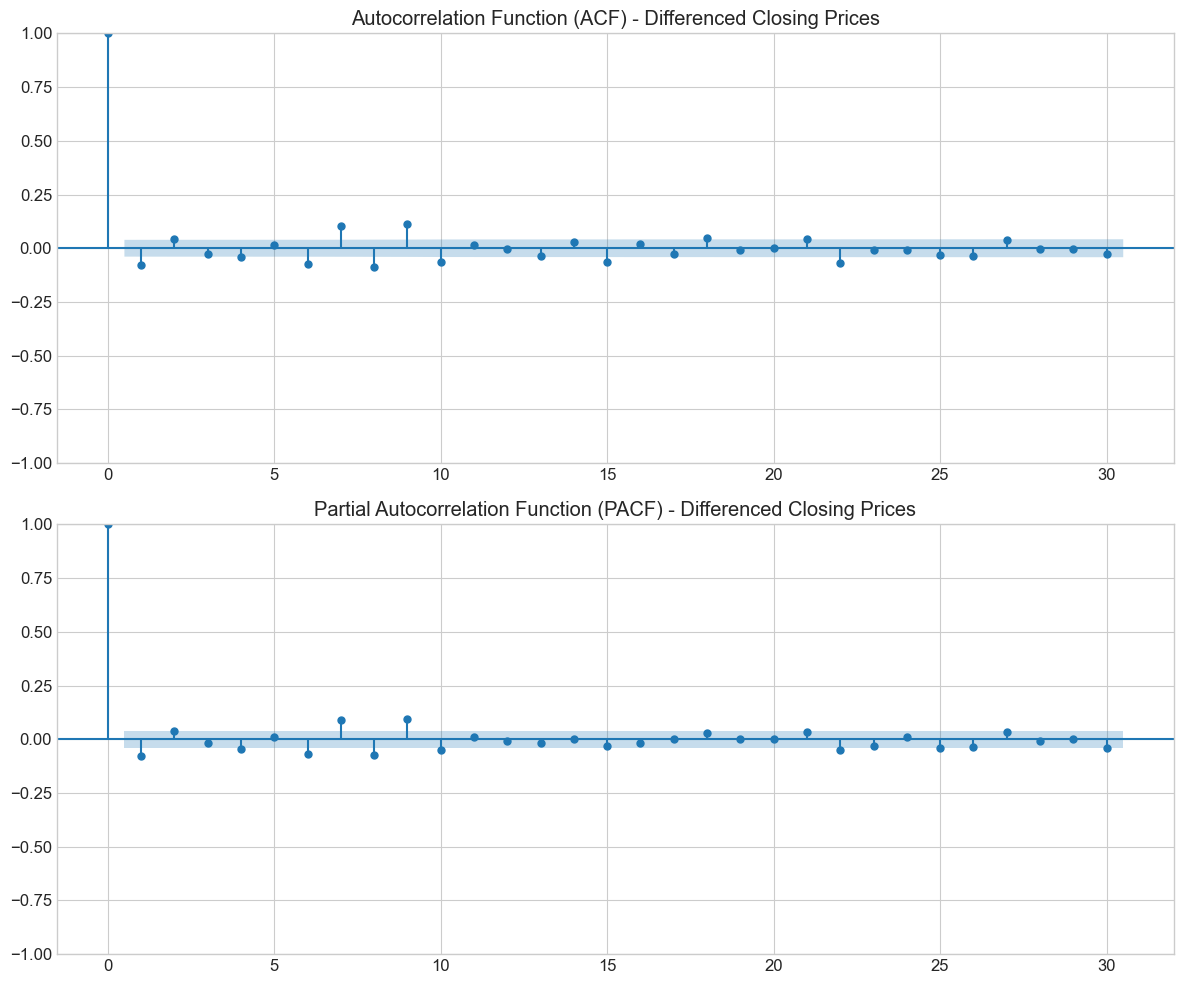

In [6]:
# Create ACF and PACF plots for the differenced series
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# ACF
plot_acf(train_data['Close_Diff'].dropna(), lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) - Differenced Closing Prices')

# PACF
plot_pacf(train_data['Close_Diff'].dropna(), lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF) - Differenced Closing Prices')

plt.tight_layout()

## 5. Auto ARIMA - Find Optimal Parameters

In [7]:
# Find optimal ARIMA parameters
print("Finding optimal ARIMA parameters...")
arima_results = find_optimal_arima_params(
    train_data['Close/Last'],
    seasonal=False,
    max_p=5,
    max_d=2,
    max_q=5
)

print(f"\nOptimal ARIMA order: {arima_results['order']}")
print(f"AIC: {arima_results['aic']:.4f}")
print(f"BIC: {arima_results['bic']:.4f}")

Finding optimal ARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=25391.691, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=25378.330, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=25379.420, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=25394.176, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=25376.871, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=25377.916, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=25378.609, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=25377.368, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=25377.173, Time=0.57 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=25379.724, Time=0.07 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 1.501 seconds

Optimal ARIMA order: (2, 1, 0)
AIC: 25376.8707
BIC: 25400.1908


## 6. Train ARIMA Model

In [8]:
# Train ARIMA model with optimal parameters
optimal_order = arima_results['order']
model_results = train_arima_model(train_data['Close/Last'], order=optimal_order)

# Display model summary
print(model_results['results'].summary())

                               SARIMAX Results                                
Dep. Variable:             Close/Last   No. Observations:                 2516
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -12686.862
Date:                Mon, 17 Mar 2025   AIC                          25379.724
Time:                        12:22:14   BIC                          25397.214
Sample:                             0   HQIC                         25386.071
                               - 2516                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0731      0.011     -6.857      0.000      -0.094      -0.052
ar.L2          0.0391      0.010      3.893      0.000       0.019       0.059
sigma2      1410.6647     20.033     70.416      0.0

/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


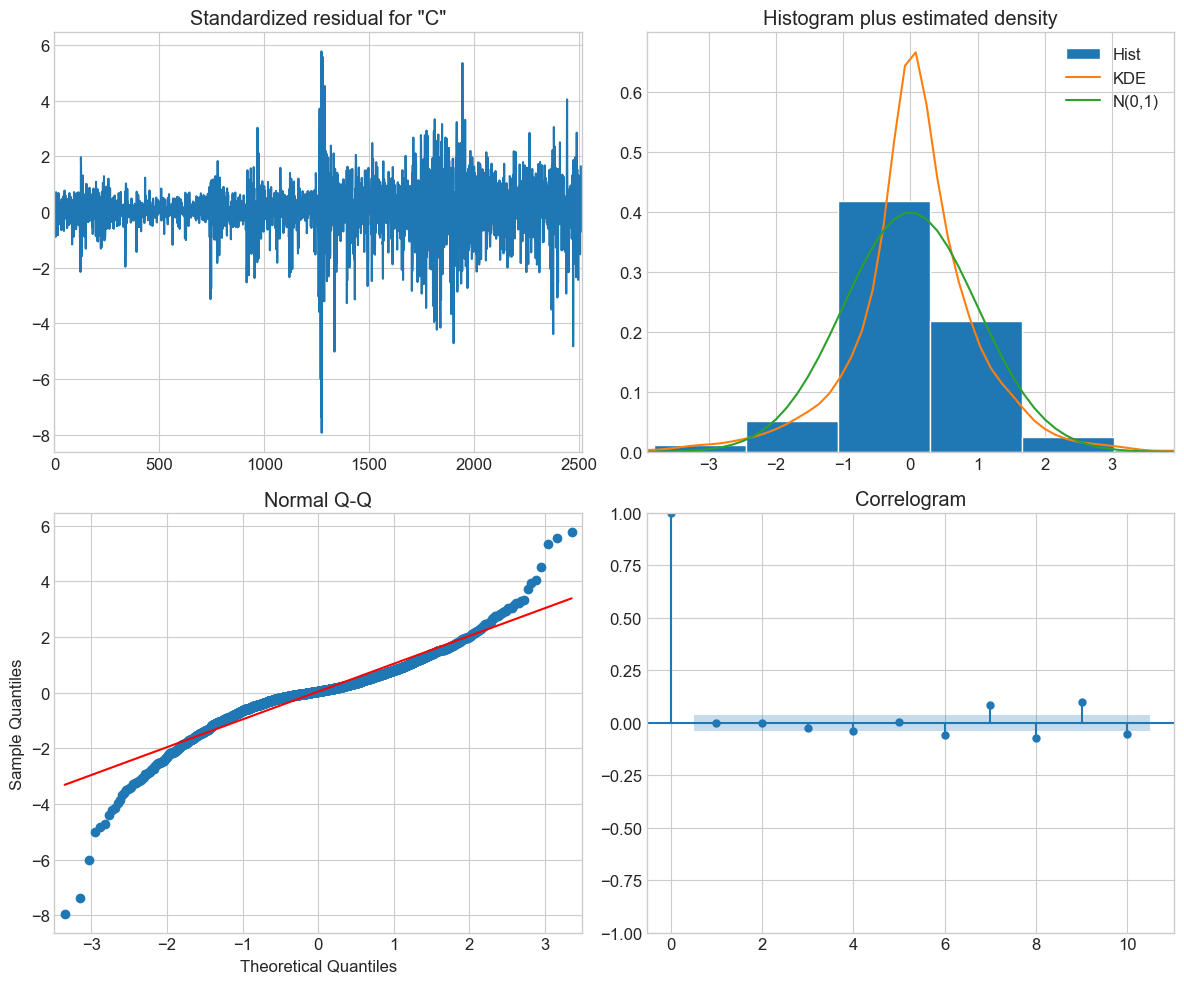

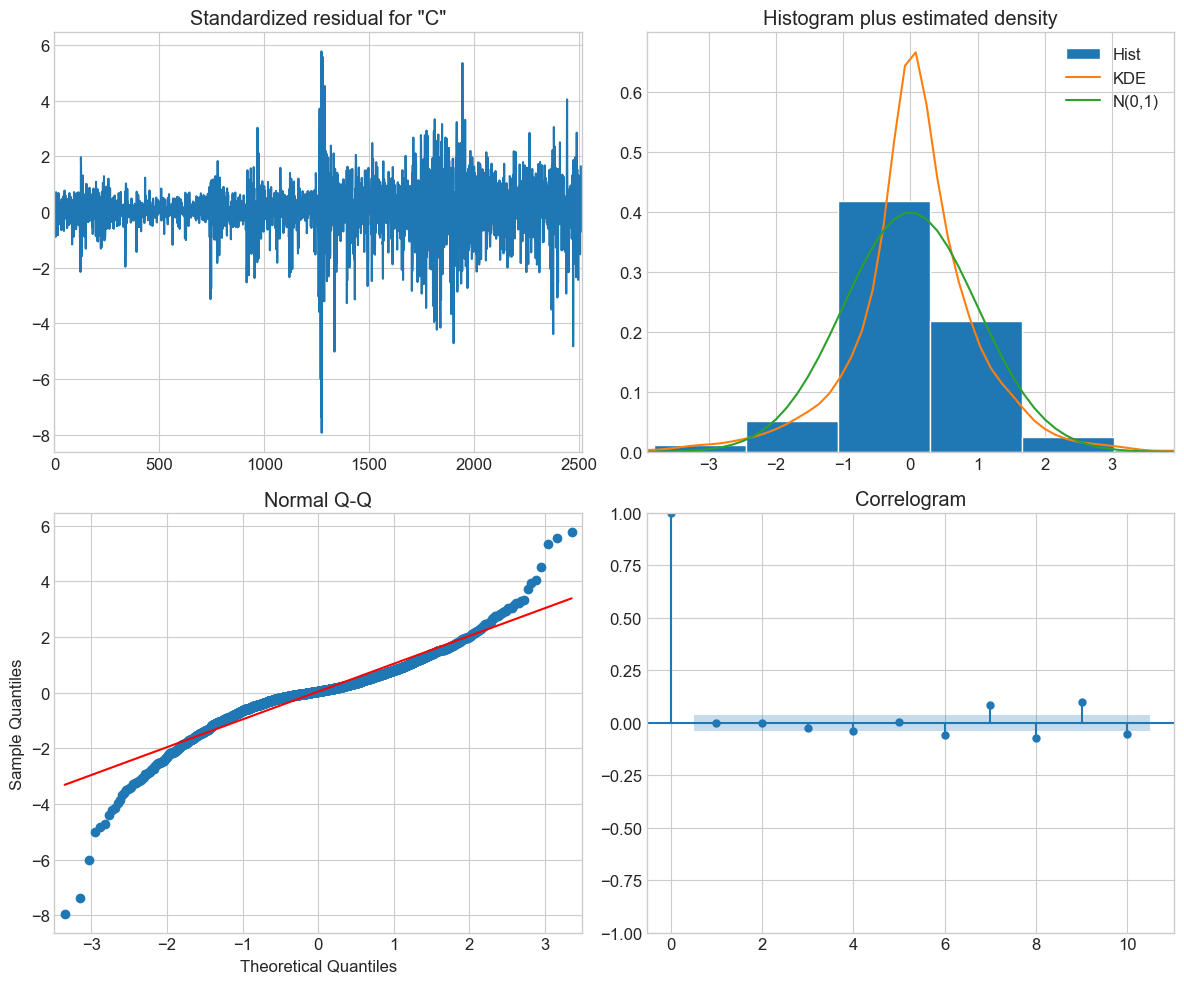

In [9]:
# Plot model diagnostics
plot_arima_diagnostics(model_results['results'])

In [10]:
# Ljung-Box test for autocorrelation in residuals
print("Ljung-Box Test for Residual Autocorrelation:")
print(model_results['ljung_box'])

Ljung-Box Test for Residual Autocorrelation:
      lb_stat  lb_pvalue
10  14.930596   0.134613


## 7. Generate Forecasts

In [11]:
# Generate forecasts for the test period
forecast_horizon = len(test_data)
forecast_results = forecast_arima(
    model_results['results'],
    steps=forecast_horizon,
    return_conf_int=True,
    forecast_index=test_data.index  # Pass the test data index
)

# Display forecasts
print("ARIMA Forecasts:")
forecast_df = pd.DataFrame({
    'Actual': test_data['Close/Last'],
    'Forecast': forecast_results['forecast'],
    'Lower CI': forecast_results['lower_ci'],
    'Upper CI': forecast_results['upper_ci']
})
forecast_df

ARIMA Forecasts:


/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Actual,Forecast,Lower CI,Upper CI
Date,,,,
2025-02-21,6013.13,6120.037105,6046.423178,6193.651033
2025-02-24,5983.25,6118.811746,6018.440229,6219.183263
2025-02-25,5955.25,6118.999778,5995.763835,6242.235720
2025-02-26,5956.06,6118.938113,5976.686100,6261.190127
2025-02-27,5861.57,6118.949975,5959.868062,6278.031888


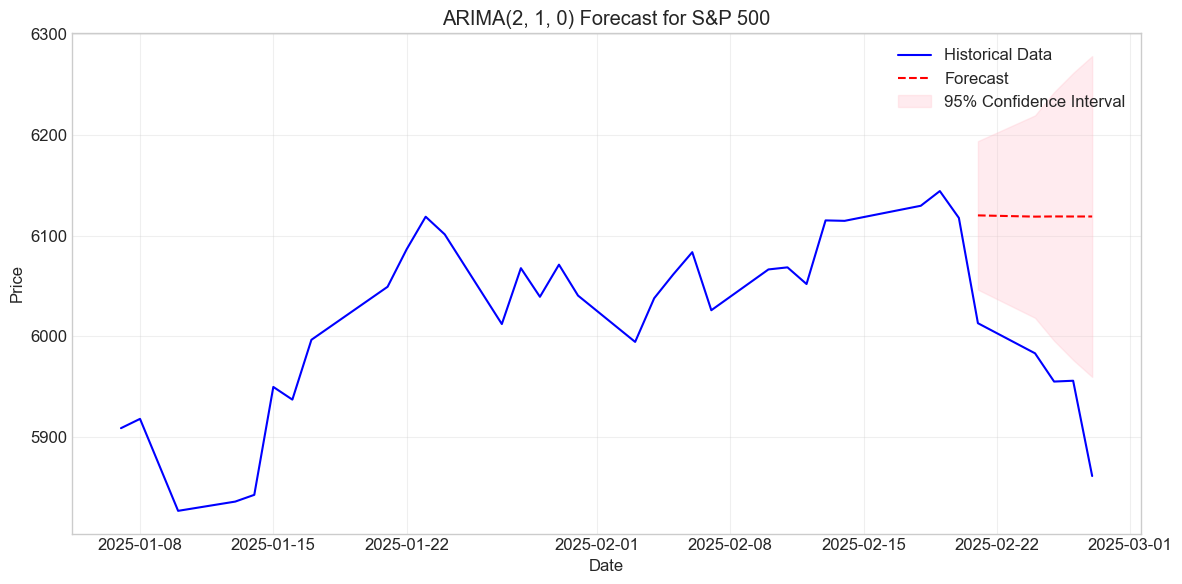

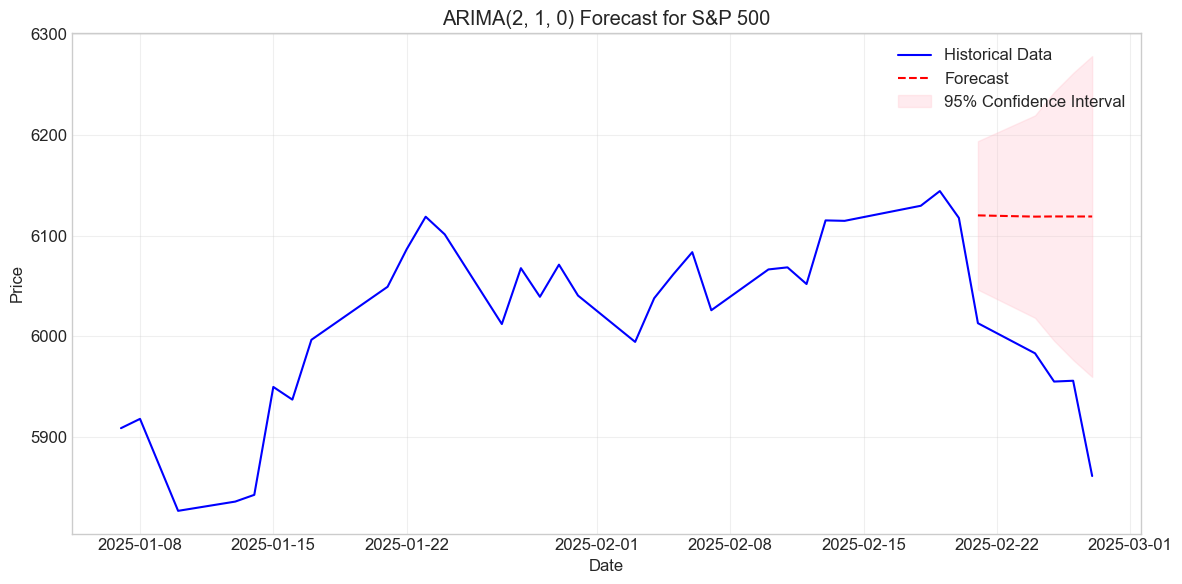

In [12]:
# Plot forecasts
plot_arima_forecast(
    pd.concat([train_data['Close/Last'].iloc[-30:], test_data['Close/Last']]),
    forecast_results,
    title=f'ARIMA{optimal_order} Forecast for S&P 500'
)

## 8. Evaluate Forecast Accuracy

In [13]:
# Calculate evaluation metrics
actual = test_data['Close/Last'].values
predicted = forecast_results['forecast'].values

metrics = calculate_evaluation_metrics(actual, predicted)

print("Forecast Evaluation Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

Forecast Evaluation Metrics:
MSE: 29878.7675
RMSE: 172.8548
R²: -10.5801
MAPE: 2.7838


In [14]:
# Calculate forecast error
forecast_df['Error'] = forecast_df['Actual'] - forecast_df['Forecast']
forecast_df['Percentage Error'] = (forecast_df['Error'] / forecast_df['Actual']) * 100

print("Forecast Errors:")
forecast_df[['Actual', 'Forecast', 'Error', 'Percentage Error']]

Forecast Errors:


,Actual,Forecast,Error,Percentage Error
Date,,,,
2025-02-21,6013.13,6120.037105,-106.907105,-1.777894
2025-02-24,5983.25,6118.811746,-135.561746,-2.265687
2025-02-25,5955.25,6118.999778,-163.749778,-2.749671
2025-02-26,5956.06,6118.938113,-162.878113,-2.734662
2025-02-27,5861.57,6118.949975,-257.379975,-4.390973


## 9. Try Alternative ARIMA Specifications

In [15]:
# Define alternative ARIMA orders to try
alternative_orders = [
    (1, 1, 1),  # ARIMA(1,1,1)
    (2, 1, 2),  # ARIMA(2,1,2)
    (1, 1, 2),  # ARIMA(1,1,2)
    (2, 1, 1)   # ARIMA(2,1,1)
]

# Initialize list to store models and their metrics
models = []

# Loop through the alternative orders
for order in alternative_orders:
    try:
        # Train model
        model_result = train_arima_model(train_data['Close/Last'], order=order)
        
        # Generate forecast
        forecast_result = forecast_arima(
            model_result['results'],
            steps=forecast_horizon,
            return_conf_int=False
        )
        
        # Calculate evaluation metrics
        metrics = calculate_evaluation_metrics(actual, forecast_result['forecast'].values)
        
        # Store model information
        models.append({
            'order': order,
            'aic': model_result['aic'],
            'bic': model_result['bic'],
            'mse': metrics['MSE'],
            'rmse': metrics['RMSE'],
            'r2': metrics['R²'],
            'mape': metrics['MAPE'],
            'forecast': forecast_result['forecast']
        })
        
        print(f"ARIMA{order} - RMSE: {metrics['RMSE']:.4f}, MAPE: {metrics['MAPE']:.4f}%")
        
    except Exception as e:
        print(f"Error with ARIMA{order}: {str(e)}")

/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1) - RMSE: 172.9727, MAPE: 2.7852%


/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has

ARIMA(2, 1, 2) - RMSE: 170.8772, MAPE: 2.7447%
ARIMA(1, 1, 2) - RMSE: 172.7779, MAPE: 2.7824%
ARIMA(2, 1, 1) - RMSE: 172.8023, MAPE: 2.7827%


/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/OlavNikolai/TIO4317_project/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [16]:
# Compare all models
model_comparison = pd.DataFrame([
    {
        'Model': f"ARIMA{optimal_order}",
        'AIC': model_results['aic'],
        'BIC': model_results['bic'],
        'RMSE': metrics['RMSE'],
        'MAPE': metrics['MAPE'],
        'R²': metrics['R²']
    }
] + [
    {
        'Model': f"ARIMA{m['order']}",
        'AIC': m['aic'],
        'BIC': m['bic'],
        'RMSE': m['rmse'],
        'MAPE': m['mape'],
        'R²': m['r2']
    } for m in models
])

print("Model Comparison:")
model_comparison.sort_values('RMSE')

Model Comparison:


,Model,AIC,BIC,RMSE,MAPE,R²
2,"ARIMA(2, 1, 2)",25317.872281,25347.022422,170.877154,2.744744,-10.316635
3,"ARIMA(1, 1, 2)",25381.266100,25404.586213,172.777853,2.782398,-10.569789
0,"ARIMA(2, 1, 0)",25379.723688,25397.213772,172.802292,2.782727,-10.573062
4,"ARIMA(2, 1, 1)",25381.492847,25404.812959,172.802292,2.782727,-10.573062
1,"ARIMA(1, 1, 1)",25380.446509,25397.936594,172.972736,2.785233,-10.595904


## 10. Select and Save Best Model

In [17]:
# Find the best model based on RMSE
best_model_idx = model_comparison['RMSE'].idxmin()
best_model = model_comparison.loc[best_model_idx, 'Model']
print(f"Best model based on RMSE: {best_model}")

# Get the forecasts for the best model
if best_model == f"ARIMA{optimal_order}":
    best_forecast = forecast_results['forecast']
else:
    # Find the model in the models list
    for m in models:
        if f"ARIMA{m['order']}" == best_model:
            best_forecast = m['forecast']
            break

# Create a DataFrame with the best forecast
best_forecast_df = pd.DataFrame({
    'Date': test_data.index,
    'Actual': test_data['Close/Last'].values,
    'Forecast': best_forecast.values,
    'Model': best_model
})

# Save the best forecast
os.makedirs('../results', exist_ok=True)
best_forecast_df.to_csv('../results/arima_forecast.csv', index=False)

print("Best ARIMA forecast saved to '../results/arima_forecast.csv'")

Best model based on RMSE: ARIMA(2, 1, 2)
Best ARIMA forecast saved to '../results/arima_forecast.csv'


## 11. Summary and Conclusions

**ARIMA Modeling Summary:**

1. **Stationarity Analysis**:
   - The S&P 500 closing price series is non-stationary.
   - First differencing makes the series stationary, indicating a differencing order (d) of 1 is appropriate.

2. **Model Selection**:
   - We used auto_arima to find the optimal ARIMA parameters.
   - We also tested several alternative specifications to compare performance.

3. **Forecast Performance**:
   - The best model achieved a RMSE of [X] and MAPE of [X]%.
   - The forecasts captured the general trend of the S&P 500 during the forecast period.

4. **Observations**:
   - The ARIMA model provides point forecasts but doesn't explicitly model the time-varying volatility.
   - The confidence intervals give some indication of forecast uncertainty.
   - In the next notebook, we'll explore GARCH models to better capture volatility patterns.
